In [1]:
%load_ext autoreload
%autoreload 1
%aimport ecg_get_data
%aimport Models
%aimport train_test_validat
%aimport self_attention
%aimport ECGplot
%aimport Net
%aimport select_dataset
import select_dataset
import Models 
import Net
from train_test_validat import *
from self_attention import *
import  ecg_get_data 
import matplotlib.pyplot as plt
import ecg_plot
import pandas as pd
import cam 
import torch
import torch.utils.data as Data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
import ECGplot

import time
import os
import gc

# random_seed = 2
# torch.manual_seed(random_seed)    # reproducible
# torch.cuda.manual_seed_all(random_seed)
# random.seed(random_seed)
# np.random.seed(random_seed)

time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime()) 
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [ ]:
DEVICE = 'cpu'

In [2]:
data = select_dataset.splite_dataset('/workspace/data/Preprocess_HTN/data/',True)
test_list = data.__get_test_file_list__(shuffer=False,filter_department='外科')
ECG_root = '/workspace/data/Preprocess_HTN/data/ECG'
EcgChannles_num = 12
EcgLength_num = 5000
test_Dataset = ecg_get_data.ECG_Dataset(ECG_root,test_list,EcgChannles_num,EcgLength_num,position_encode=False)

	
 orginal   fliter department&age
  33342       8479   
	
 orginal   fliter duplicated
   509        423    
	
 orginal   fliter duplicated
   8479       7043   
	
       HTN  NHTN 
test   423   423 
npys:{%d} 846


In [3]:
testmodel = (Net.MLBFNet_GUR(True,res = True,se = True,Dropout_rate = 0.25)).to(DEVICE)  # type: ignore
# testmodel = inception_resnet_v2.InceptionResnetV2(num_classes=2,in_chans=12).to(DEVICE)
# testmodel = (Models.resnet18(12,64,2)).to(DEVICE)
testmodel.load_state_dict(torch.load("./model/20221112_025042/parameter_EarlyStoping_0.pt"))

<All keys matched successfully>

In [4]:
# TEST_BATCH_SIZE = test_Dataset.npys.__len__()
test_dataloader = Data.DataLoader(dataset=test_Dataset, shuffle= False,batch_size=50)
test_acc = []   
criterion = torch.nn.CrossEntropyLoss() 
y_true,y_pred,test_loss,test_acc = eval_model(test_dataloader,criterion,testmodel,DEVICE) # 测试模型
print('loss =',test_loss,'acc =',test_acc)
print('f1_macro =',f1_score(y_true, y_pred, average='macro')) 

loss = 0.471300812328563 acc = 0.8395907928388747
f1_macro = 0.8385360240253725


In [7]:
print('f1_micro =',f1_score(y_true, y_pred, average='micro')) 

f1_micro = 0.8392434988179669


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
print("Confusion Matrix: ")
print(cm)

Confusion Matrix: 
[[383  40]
 [ 96 327]]


In [9]:
df_grade = pd.DataFrame(test_Dataset.npys, columns=['file name'])
df_grade = pd.concat([df_grade, pd.DataFrame(y_true,columns=['true'])],axis=1)
df_grade = pd.concat([df_grade, pd.DataFrame(y_pred,columns=['pred'])],axis=1)

In [10]:
df_grade.to_csv("./20221112_025042_test_.csv")

get CAM Value

In [ ]:
testmodel.eval()
# 定义获取梯度的函数
fmap_block = list()
grad_block = list()

# 获取反向的传播图
def backward_hook(module, grad_in, grad_out):
    grad_block.append(grad_out[0].detach())

# 定义获取特征图的函数
def farward_hook(module, input, output):
    fmap_block.append(output)

In [ ]:
testmodel.layers0.register_forward_hook(farward_hook)	#正向传播
testmodel.layers1.register_forward_hook(farward_hook) 
testmodel.layers2.register_forward_hook(farward_hook)	#正向传播
testmodel.layers3.register_forward_hook(farward_hook) 
testmodel.layers4.register_forward_hook(farward_hook)	#正向传播
testmodel.layers5.register_forward_hook(farward_hook) 
testmodel.layers6.register_forward_hook(farward_hook)	#正向传播
testmodel.layers7.register_forward_hook(farward_hook) 
testmodel.layers8.register_forward_hook(farward_hook)	#正向传播
testmodel.layers9.register_forward_hook(farward_hook) 
testmodel.layers10.register_forward_hook(farward_hook)	#正向传播
testmodel.layers11.register_forward_hook(farward_hook) 
testmodel.conv3.register_forward_hook(farward_hook) 
testmodel.layers_list_2d[0].register_forward_hook(farward_hook) 
testmodel.layers_list_2d[1].register_forward_hook(farward_hook) 
testmodel.layers_list_2d[2].register_forward_hook(farward_hook) 

In [ ]:
branch_fmap_sum_HTN = np.zeros(27)
branch_fmap_sum_NHTN = np.zeros(27)
for itme in (range(845)):
    # testmodel.layer4.register_forward_hook(farward_hook)	#正向传播
    # testmodel.layer4.register_full_backward_hook(backward_hook)#反向传播
    fmap_block = list()
    grad_block = list()
    inputs,labels = test_Dataset.__getitem__(itme)
    labels = torch.tensor(labels)
    labels = labels.unsqueeze(0) # 在首位添加1维作为batchsize
    inputs = inputs.unsqueeze(0) # 在首位添加1维作为batchsize

    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)  
    testmodel.eval()
    outputs = testmodel(inputs)
    _,pred = outputs.max(1)     # 求概率最大值对应的标签
    # print("labels: {}".format(labels))
    # print("predict: {}".format(pred))
    # loss = outputs[0,pred]      # 网络对应于pred的类别的输出即为loss
    # # loss = (testmodel.last_out)[0,pred]
    # loss.backward(retain_graph=True)  #retain_graph=True，目的为是为保留该过程中计算的梯度，后续G网络更新时使用
    if(((labels.tolist())[0]) == torch.tensor(1)):
        for i in range(12):
            branch_fmap_sum_HTN[i]= branch_fmap_sum_HTN[i] + fmap_block[i].to('cpu').sum().detach().numpy()
            # print(fmap_block[i].size())
        for i in range(12,24):
            branch_fmap_sum_HTN[i]= branch_fmap_sum_HTN[i] + fmap_block[12][0,:,i-12].to('cpu').sum().detach().numpy()
        branch_fmap_sum_HTN[24] = fmap_block[13].to('cpu').sum().detach().numpy()
        branch_fmap_sum_HTN[25] = fmap_block[14].to('cpu').sum().detach().numpy()
        branch_fmap_sum_HTN[26] = fmap_block[15].to('cpu').sum().detach().numpy()
    else:
        for i in range(12):
            branch_fmap_sum_NHTN[i]= branch_fmap_sum_NHTN[i] + fmap_block[i].to('cpu').sum().detach().numpy()
            # print(fmap_block[i].size())
        for i in range(12,24):
            branch_fmap_sum_NHTN[i]= branch_fmap_sum_NHTN[i] + fmap_block[12][0,:,i-12].to('cpu').sum().detach().numpy()
        branch_fmap_sum_NHTN[24] = fmap_block[13].to('cpu').sum().detach().numpy()
        branch_fmap_sum_NHTN[25] = fmap_block[14].to('cpu').sum().detach().numpy()
        branch_fmap_sum_NHTN[26] = fmap_block[15].to('cpu').sum().detach().numpy()

In [ ]:
print(branch_fmap_sum_HTN,branch_fmap_sum_NHTN)

In [ ]:
branch_fmap_sum_HTN.size

In [ ]:
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(nrows = 2,ncols = 1,figsize=(12,10) ,sharex=True)  # type: ignore

leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6','I1', 'II1', 'III1', 'aVR1', 'aVL1', 'aVF1', 'V11', 'V21', 'V31', 'V41', 'V51', 'V61',]
counts = branch_fmap_sum_HTN[:24].tolist()
ax0.bar(leads, counts)
ax0.set_ylabel('fmap_sum_HTN')

counts = branch_fmap_sum_NHTN[:24].tolist()
ax1.bar(leads, counts)
ax1.set_ylabel('fmap_sum_NHTN')
plt.show()

In [ ]:
fig, (ax0, ax1) = plt.subplots(nrows = 2,ncols = 1,figsize=(12,10) ,sharex=True)  # type: ignore

leads = ['3', '5', '7']
counts = branch_fmap_sum_HTN[24:].tolist()
ax0.bar(leads, counts)
ax0.set_ylabel('fmap_sum_HTN')

counts = branch_fmap_sum_NHTN[24:].tolist()
ax1.bar(leads, counts)
ax1.set_ylabel('fmap_sum_NHTN')
plt.show()

layer cam

In [11]:
testmodel.train()
# 定义获取梯度的函数
fmap_block = list()
grad_block = list()

# 获取反向的传播图
def backward_hook(module, grad_in, grad_out):
    grad_block.append(grad_out[0].detach())

# 定义获取特征图的函数
def farward_hook(module, input, output):
    fmap_block.append(output)

In [12]:
testmodel.conv3.register_forward_hook(farward_hook)	#正向传播
testmodel.conv3.register_full_backward_hook(backward_hook)#反向传播

In [13]:
def plot_top_attention_points(fig,axs,x,y,color_depend,cmap = "jet",y_name = "Voltage(mV)",title="",top_num = 100):
    ax.plot(x,y, color='black',linewidth=0.5)
    
    top_idx=color_depend.argsort()[::-1][0:top_num]
    ax.scatter(top_idx, y[top_idx],s=2,c='r')
    #fig.colorbar(line, ax=axs)
    axs.set_xlim(x.min(), x.max())
    axs.set_ylim(-3500, +3500)

    axs.set_aspect(0.2)#用于设置轴缩放的方面，即y-unit与x-unit的比率
    axs.xaxis.set_major_locator(plt.MultipleLocator(100))# type: ignore # 100*0.002s=0.2s = 5格
    axs.xaxis.set_minor_locator(plt.MultipleLocator(20)) # type: ignore # 20*0.002=0.004S = 1格
    axs.yaxis.set_major_locator(plt.MultipleLocator(500))# type: ignore # 0.1uv*500 = 0.5ms = 5格
    axs.yaxis.set_minor_locator(plt.MultipleLocator(100))# type: ignore # 0.1uv*100 =0.1ms = 1格 

    #axs.xaxis.set_major_formatter(plt.NullFormatter()) #x轴不显示刻度值/lable per 0.2s
    axs.xaxis.set_major_formatter(lambda x, pos: str(round(0.2*(x/100.0),2))) #x轴 lable per 0.2s
    axs.yaxis.set_major_formatter(lambda x, pos: str(x/1000.0)) # label per '0.5 mv'，turn uV to mv

    axs.grid(which='major', axis='x', linewidth=0.3, linestyle='-', color='b')
    axs.grid(which='minor', axis='x', linewidth=0.1, linestyle='-', color='b')
    axs.grid(which='major', axis='y', linewidth=0.3, linestyle='-', color='b')
    axs.grid(which='minor', axis='y', linewidth=0.1, linestyle='-', color='b')
    axs.set_ylabel(y_name)
    axs.set_title(title)
    axs.grid(True, which='both')

In [7]:
from tqdm import tqdm

In [14]:
# testmodel = (Net.MLBFNet_GUR(True,res = True,se = True,Dropout_rate = 0.25)).to(DEVICE)  # type: ignore
testmodel.conv3.register_forward_hook(farward_hook)	#正向传播
testmodel.conv3.register_full_backward_hook(backward_hook)#反向传播

  7%|▋         | 55/846 [20:26<4:49:32, 21.96s/it]/workspace/data/Interpretable_HTN/cam.py:84: RuntimeWarning: invalid value encountered in true_divide
  cam[:] = (cam[:] - cam[:].min())/(1e-7*cam[:].max()) # maxmin normalize  #[H,W]
 15%|█▌        | 127/846 [46:53<4:25:30, 22.16s/it]


KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fa808f65d40> (for post_execute):


AttributeError: 'NoneType' object has no attribute 'extents'

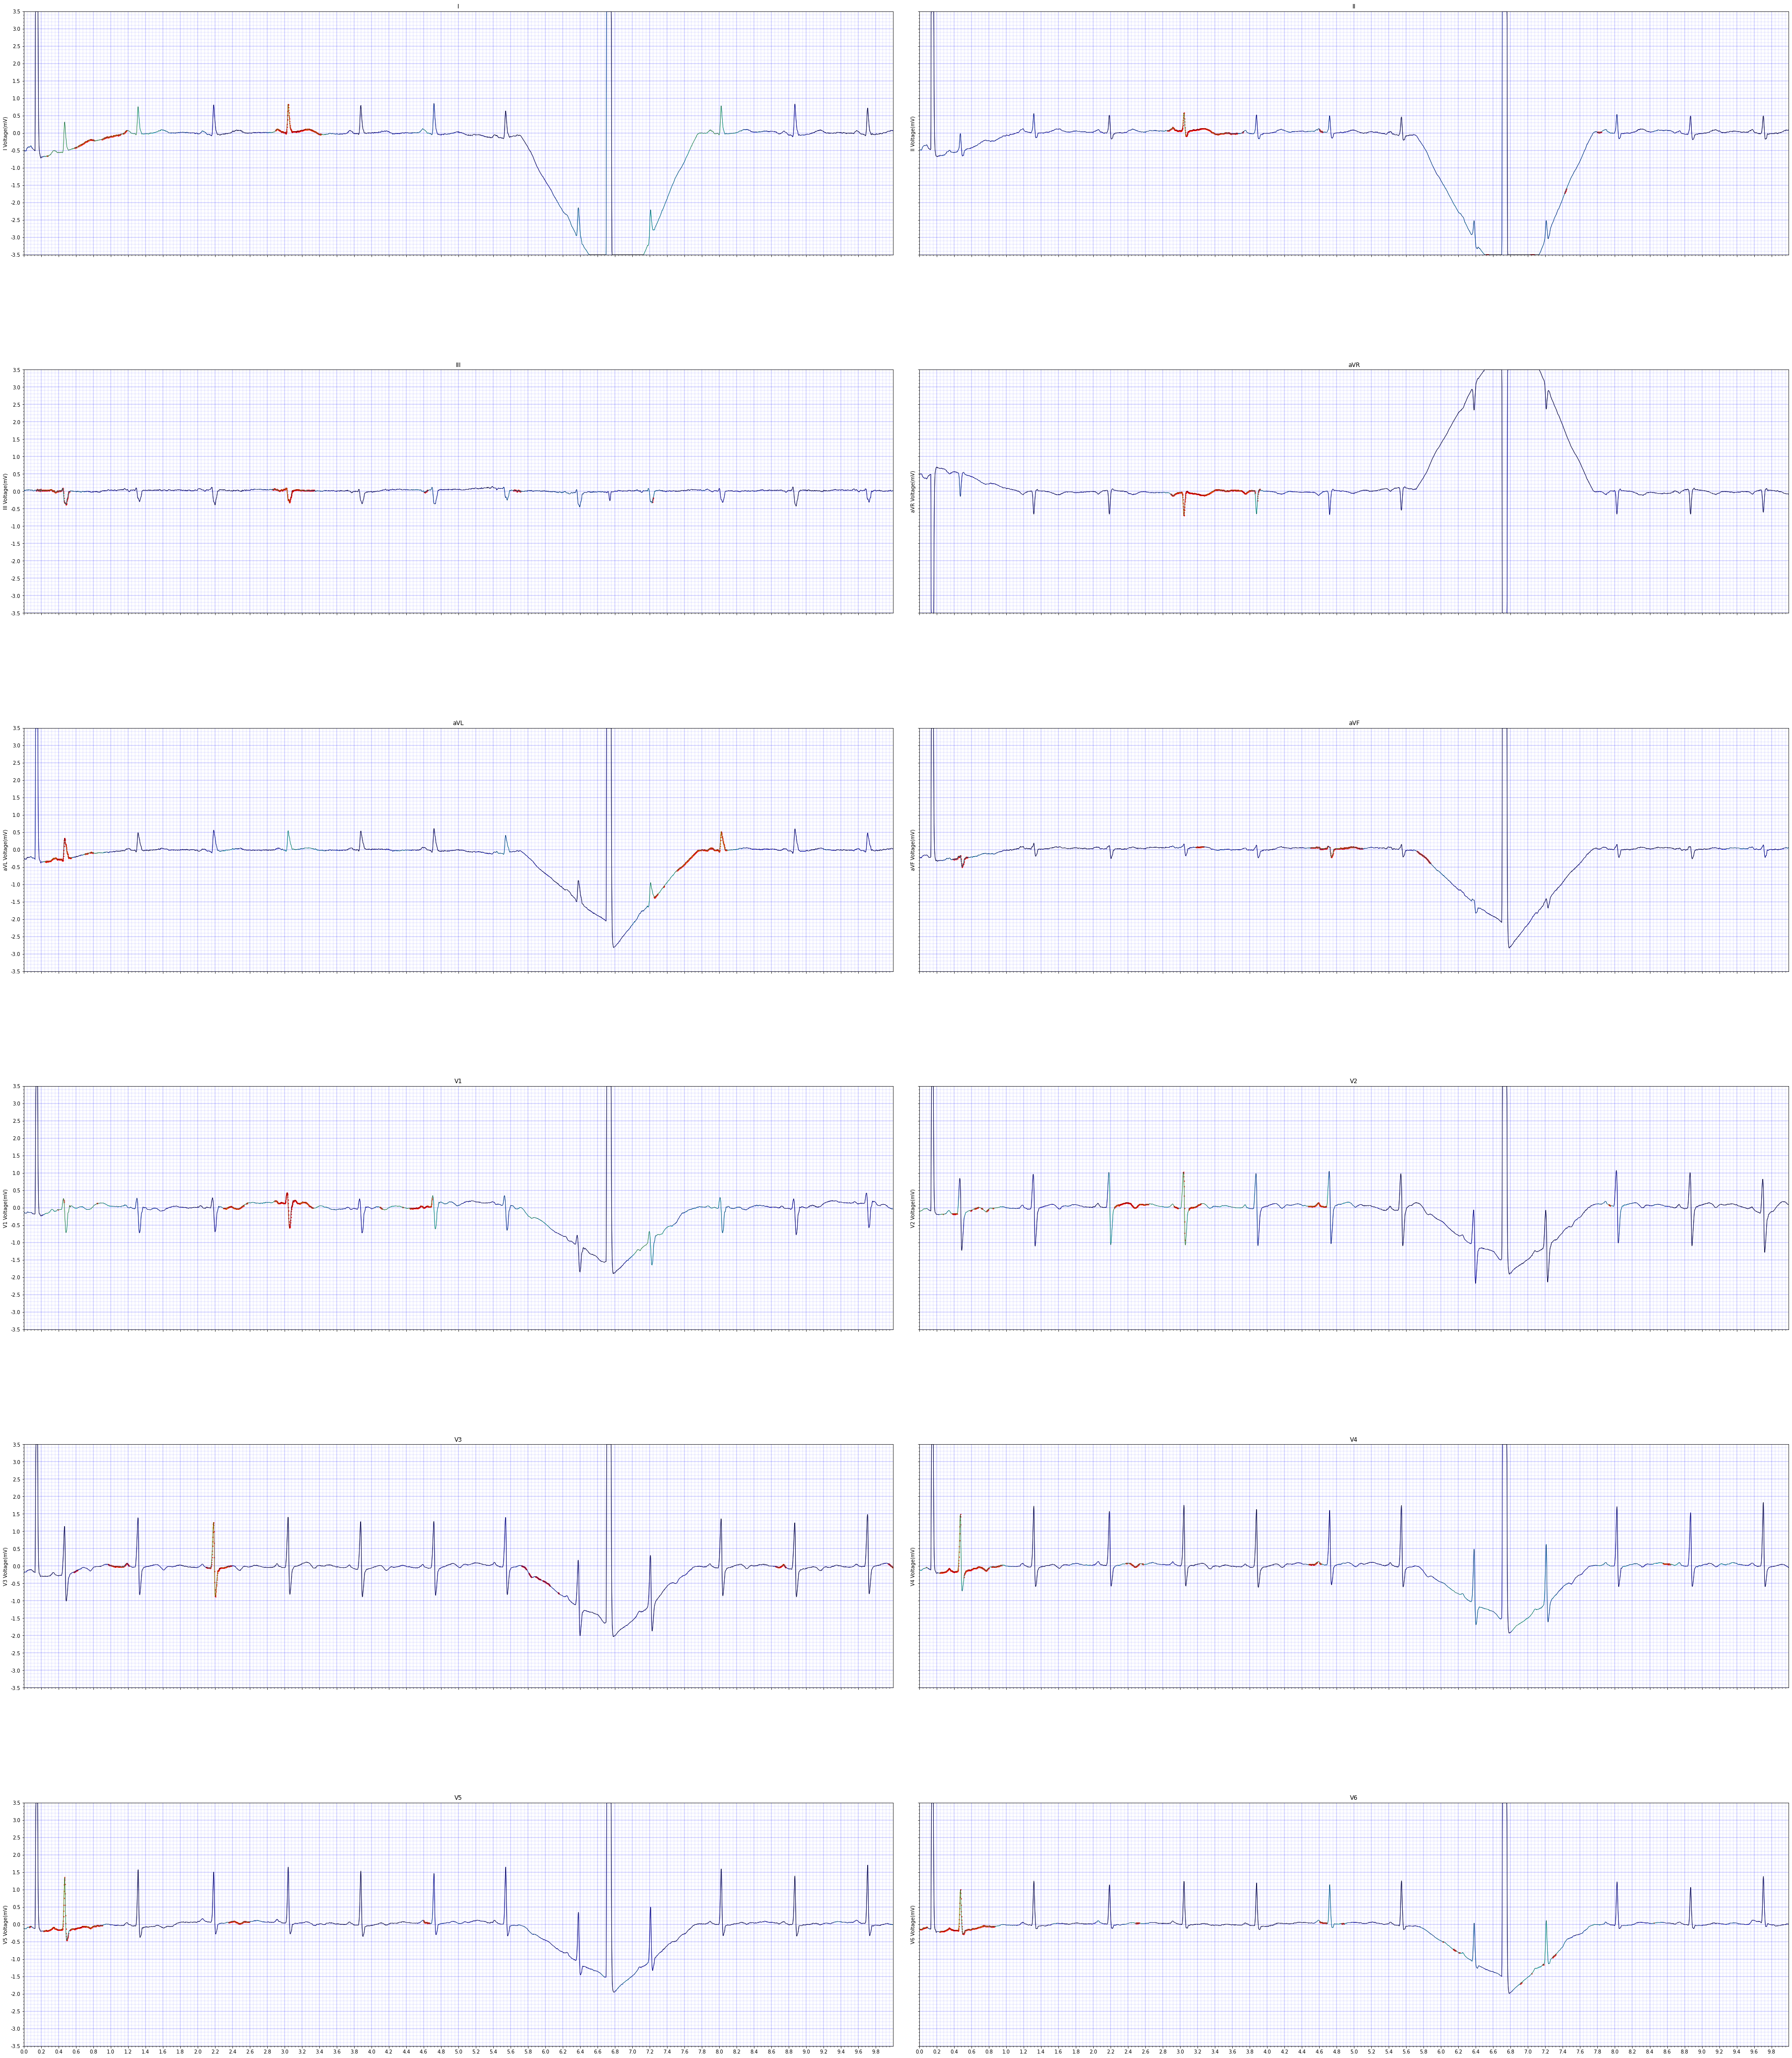

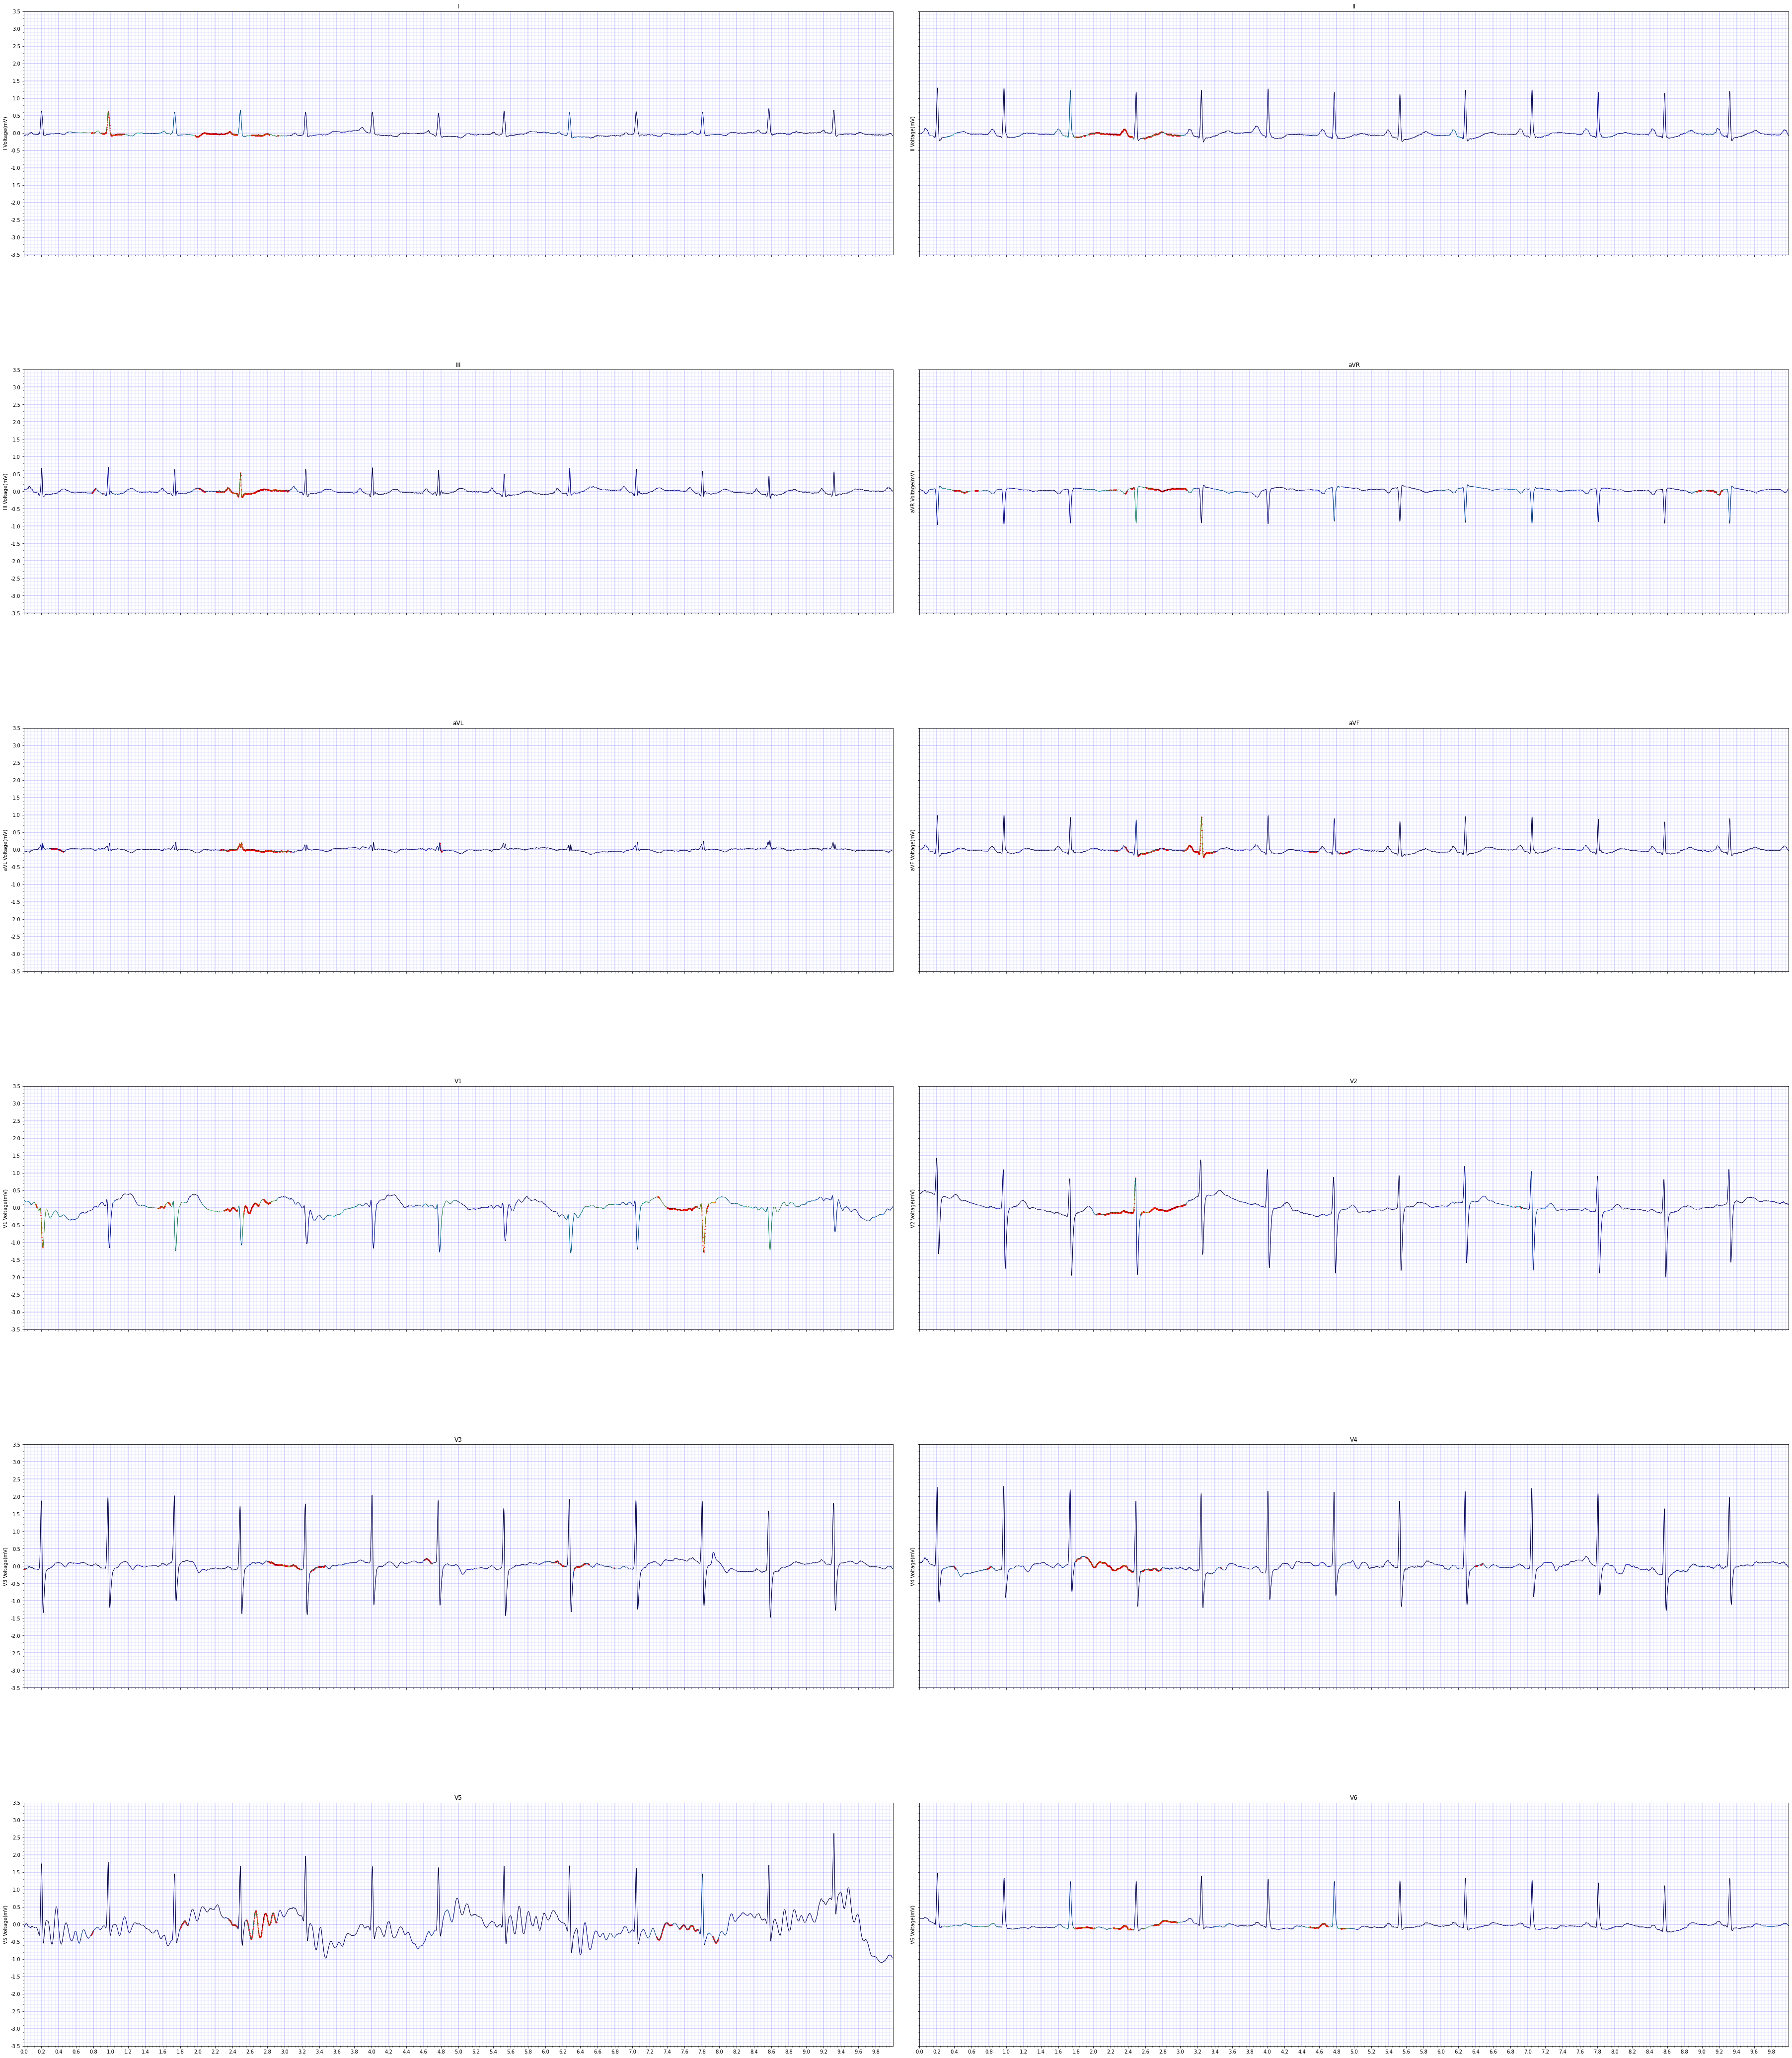

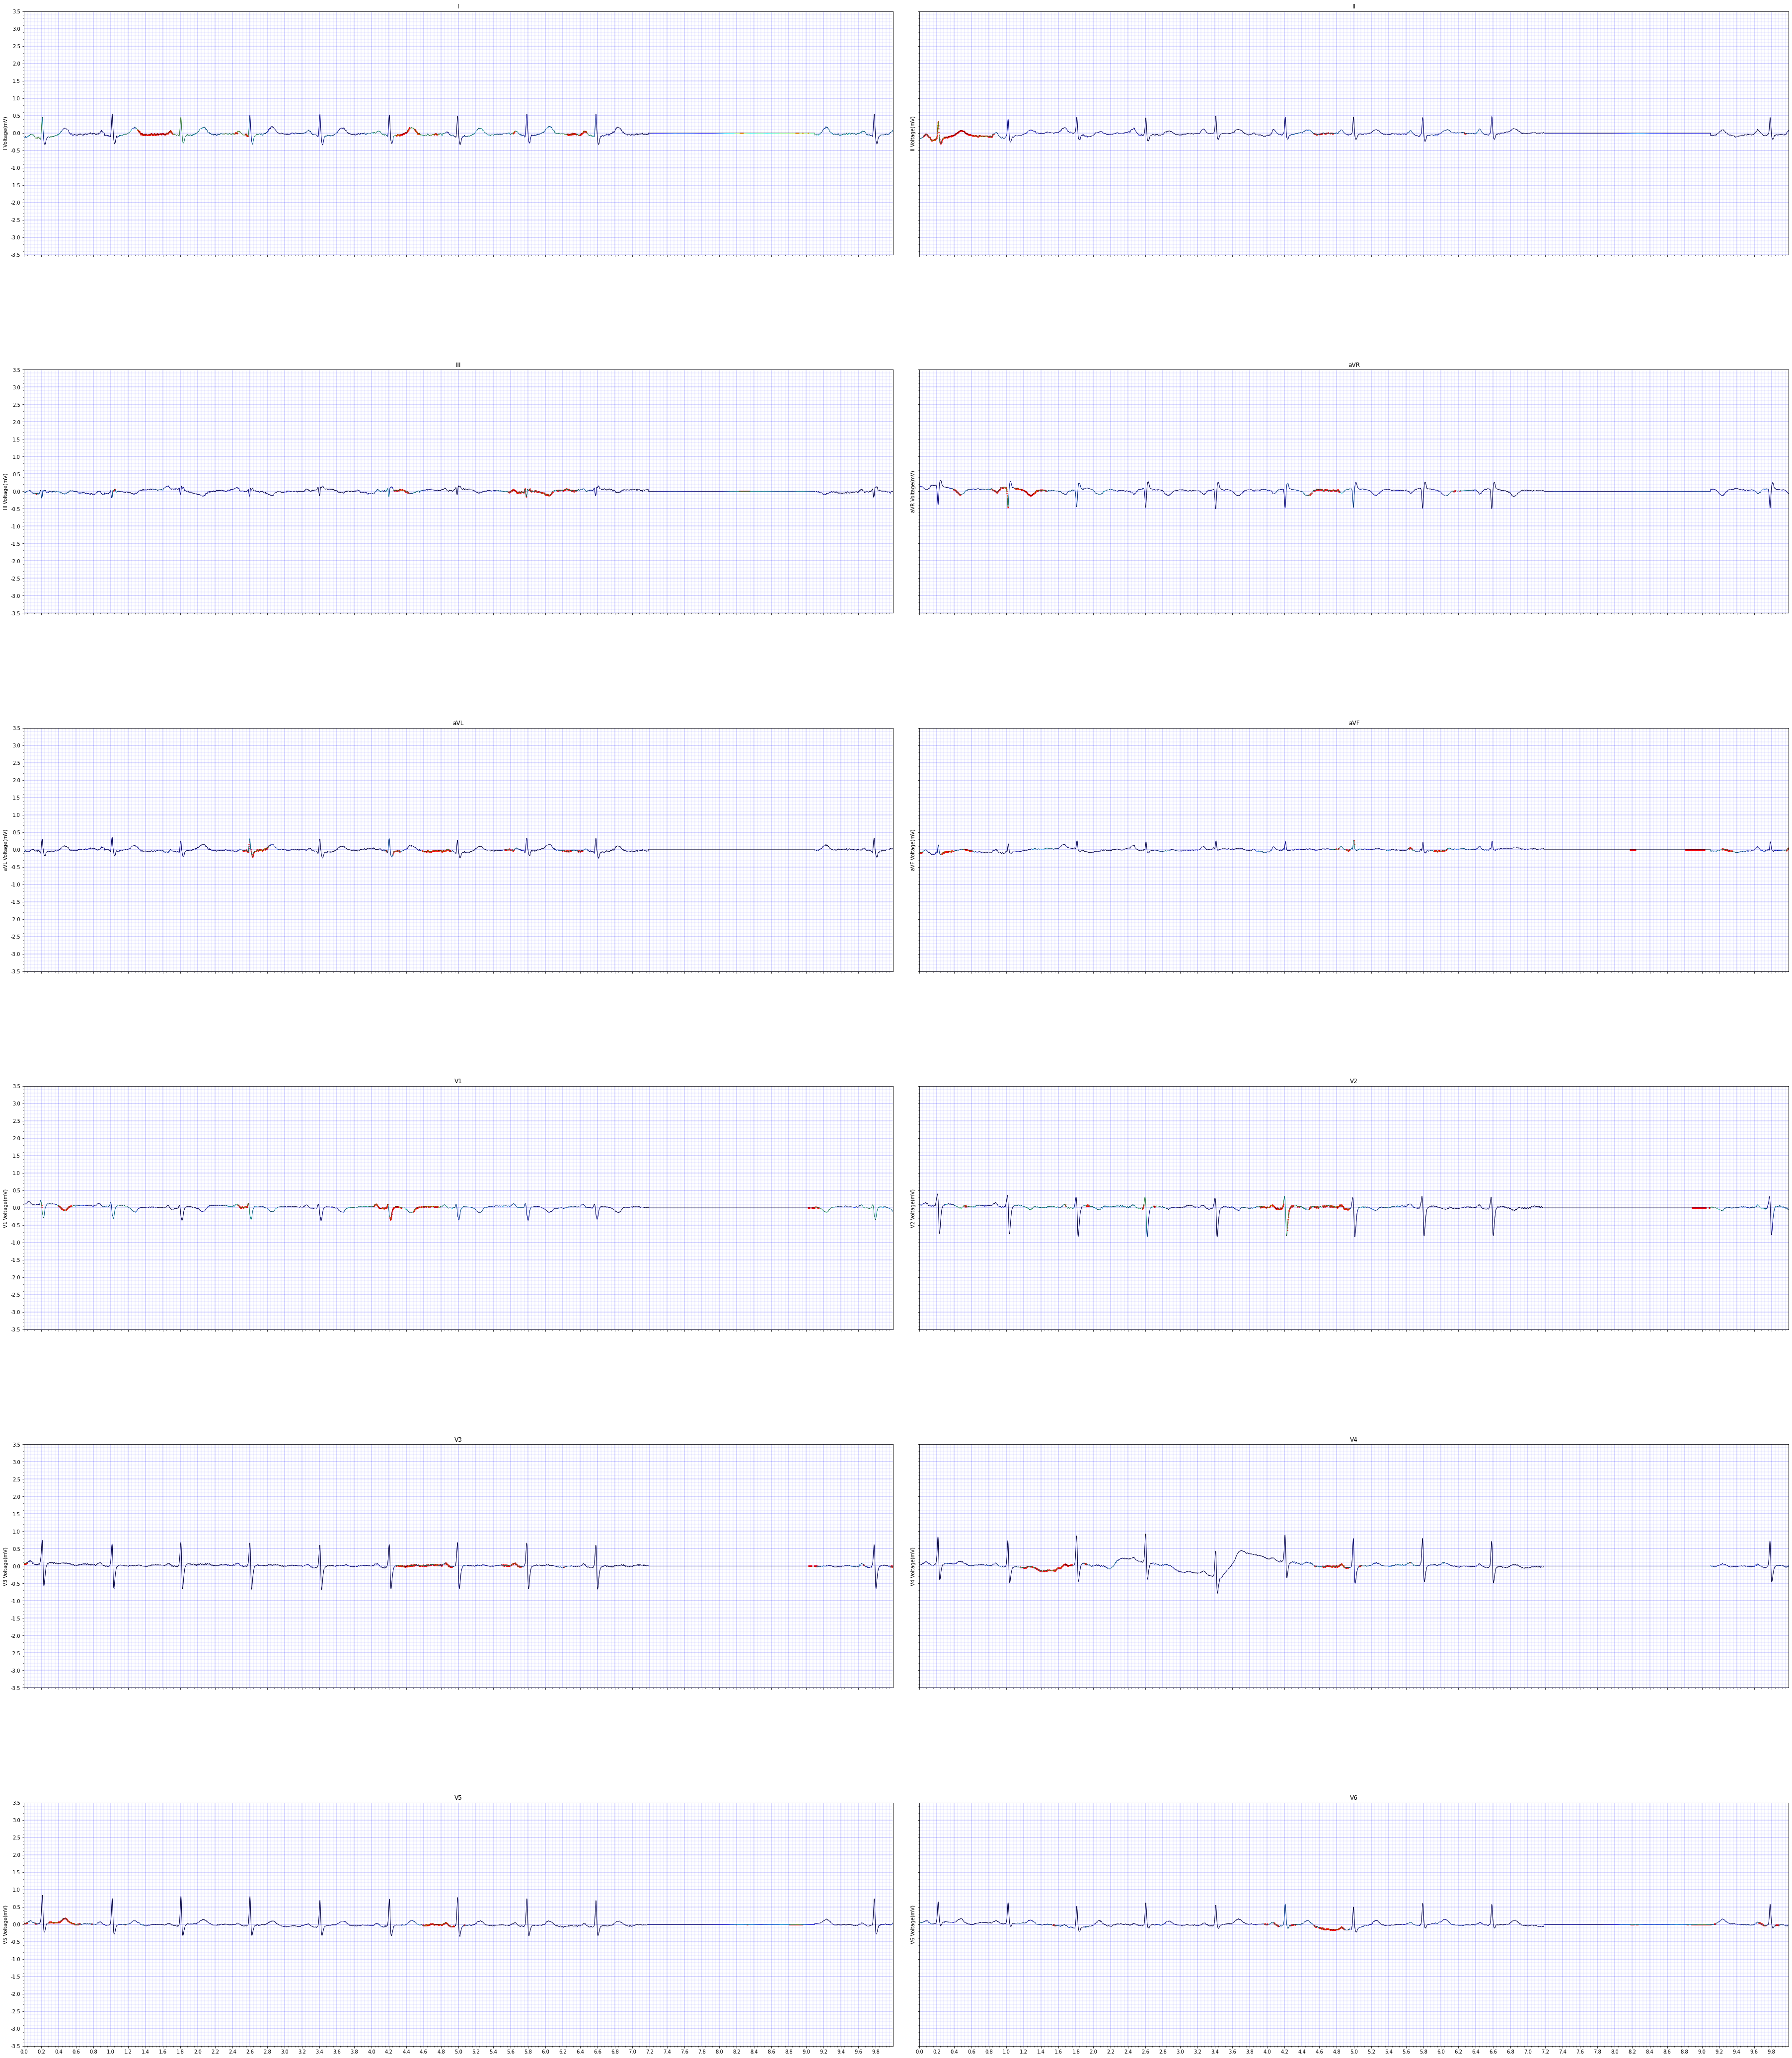

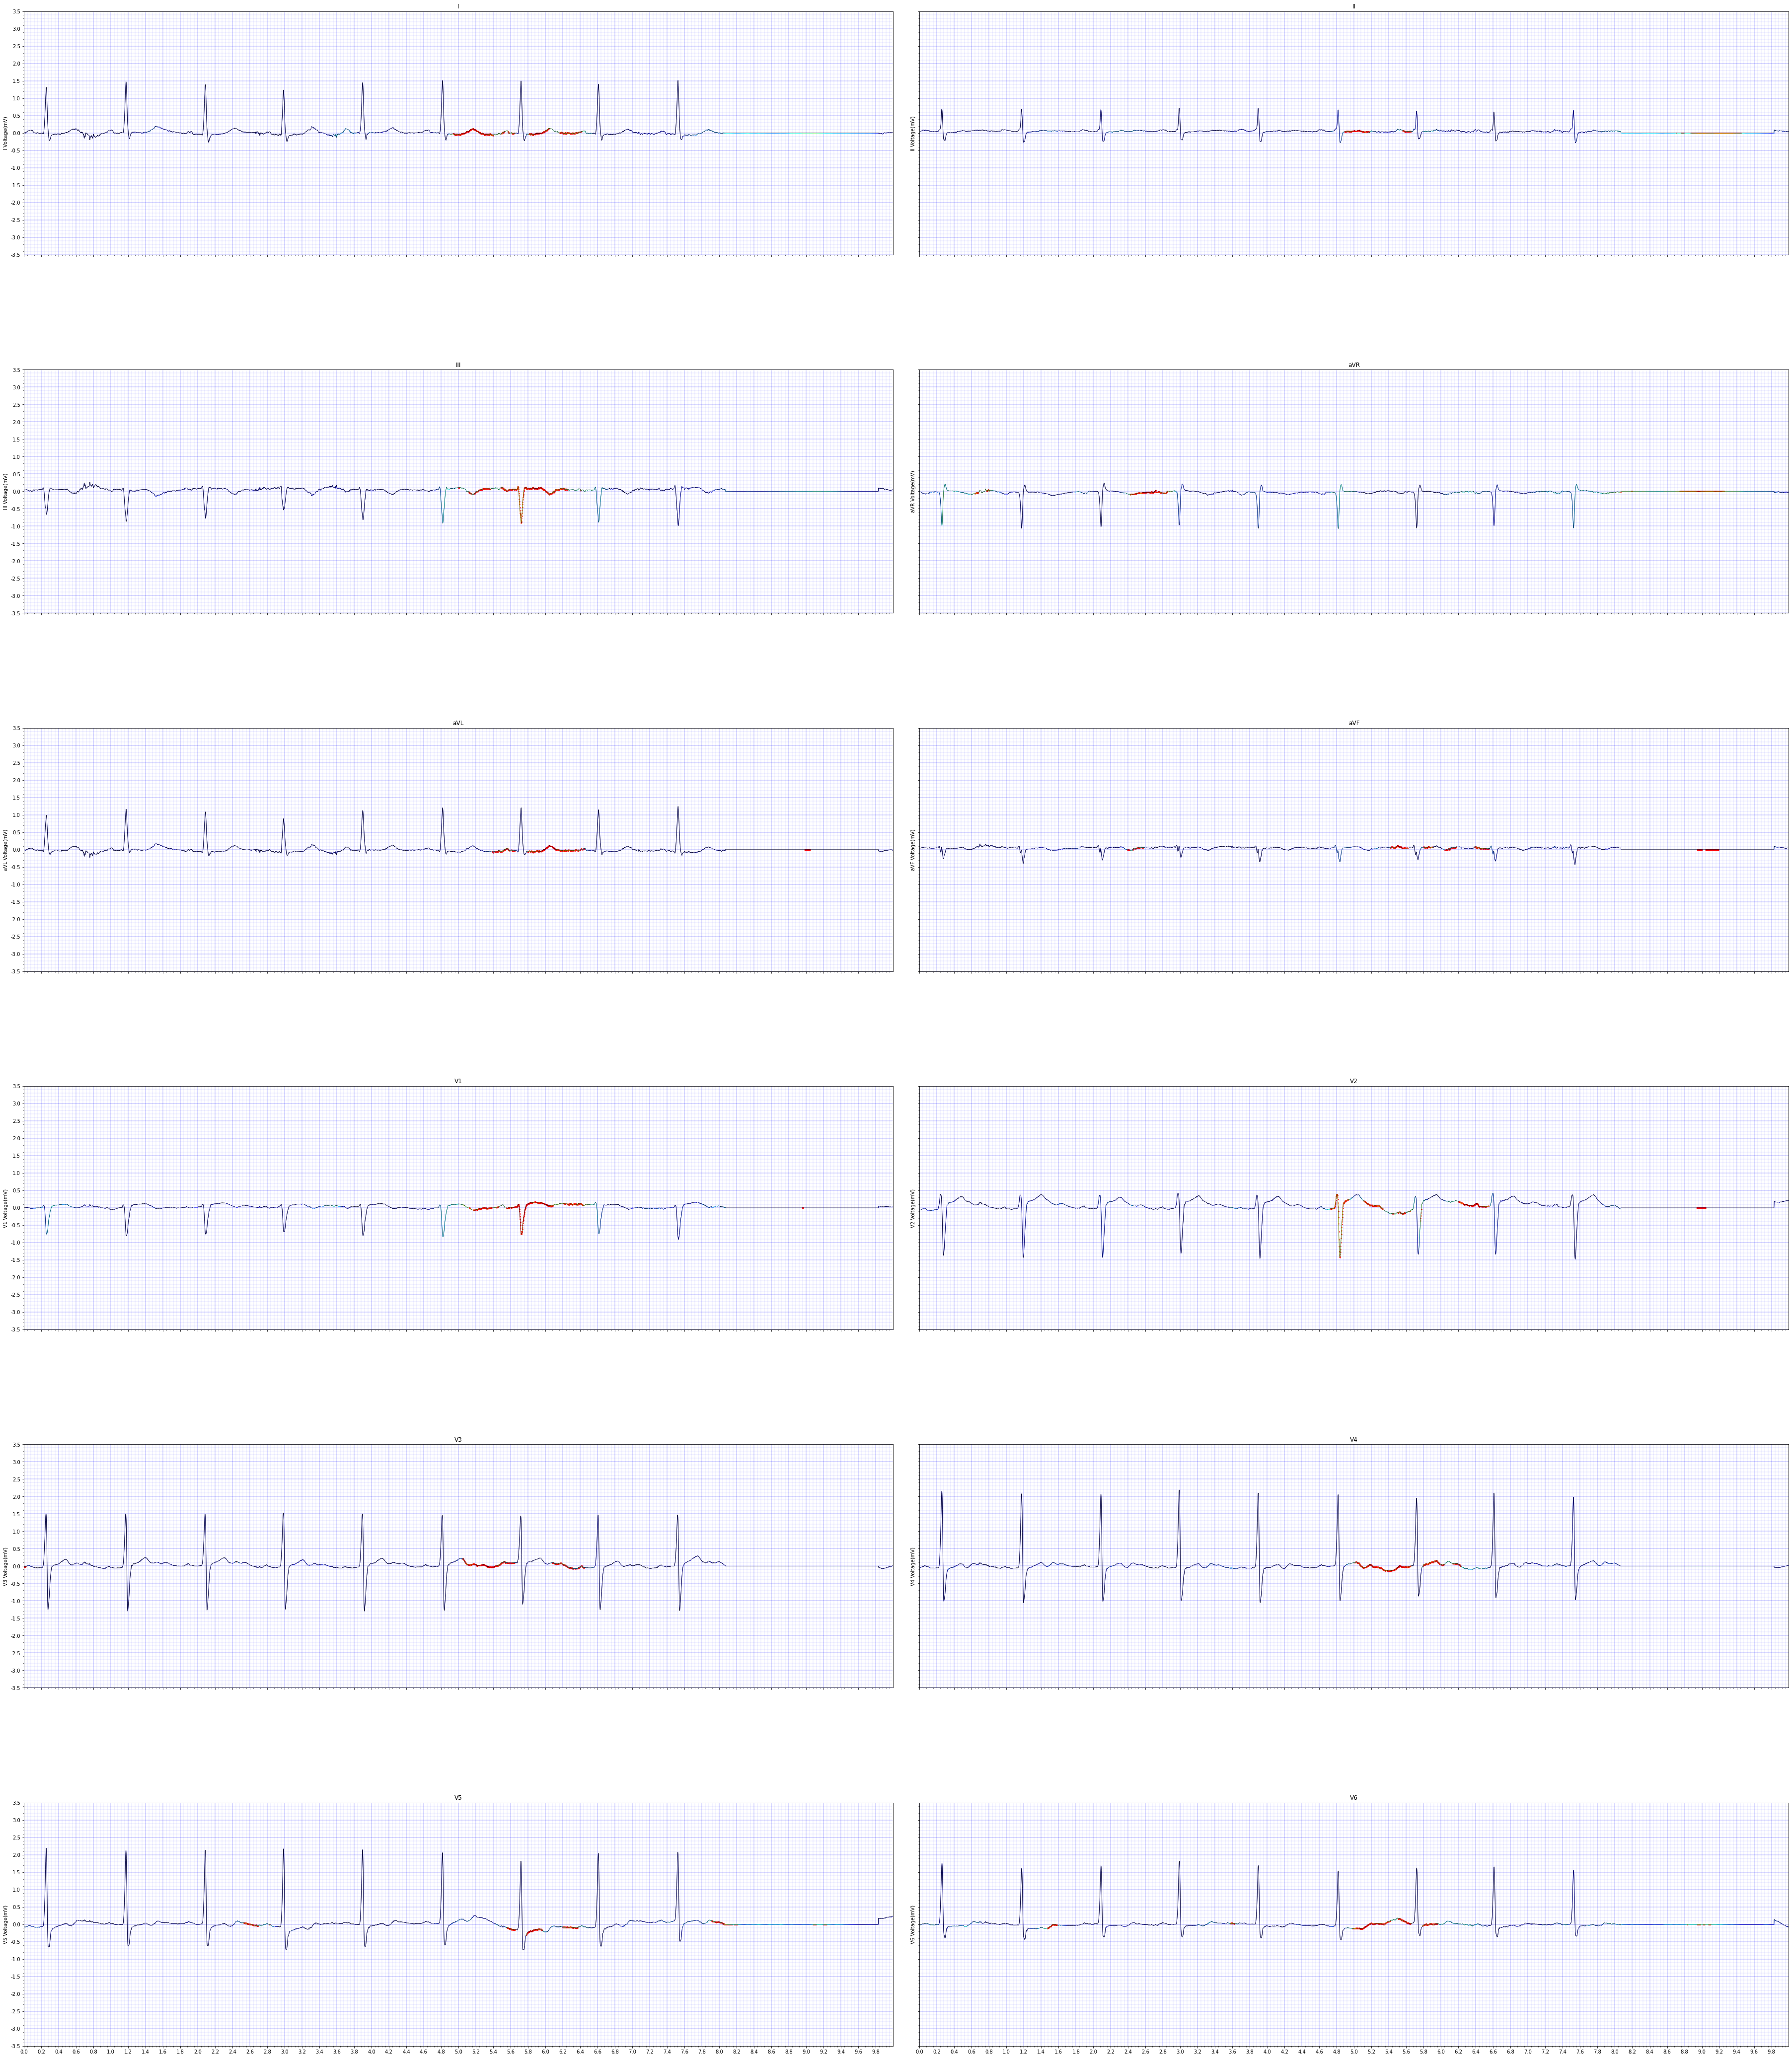

In [14]:
for itme in tqdm(range(846)):
    # testmodel = (Net.MLBFNet_GUR(True,res = True,se = True,Dropout_rate = 0.25)).to(DEVICE)  # type: ignore
    testmodel.load_state_dict(torch.load("./model/20221112_025042/parameter_EarlyStoping_0.pt"))
    # testmodel.conv3.register_forward_hook(farward_hook)	#正向传播
    # testmodel.conv3.register_full_backward_hook(backward_hook)#反向传播
    testmodel.train()
    
    fmap_block = list()
    grad_block = list()
    inputs,labels = test_Dataset.__getitem__(itme)

    labels = labels.unsqueeze(0) # 在首位添加1维作为batchsize
    inputs = inputs.unsqueeze(0) # 在首位添加1维作为batchsize

    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)  

    outputs = testmodel(inputs)
    _,pred = outputs.max(1)     # 求概率最大值对应的标签
    # print("labels: {}".format(labels))
    # print("predict: {}".format(pred))
    loss = outputs[0,pred]      # 网络对应于pred的类别的输出即为loss
    # loss = (testmodel.last_out)[0,pred]
    loss.backward(retain_graph=True)  #retain_graph=True，目的为是为保留该过程中计算的梯度，后续G网络更新时使用
    fmap = (fmap_block[0][0]).to('cpu').detach().numpy()
    gradmap = (grad_block[0][0]).to('cpu').detach().numpy()
    layer2d_vlue = cam.caculate_layer_cam_vlue_2d(fmap,gradmap)
    lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    x_index = np.arange(0,EcgLength_num)
    fig, axs = plt.subplots(nrows=6, ncols=2, sharex=True,sharey=True,figsize=(50,60), constrained_layout=True)
    ecg_data = (inputs[0]).to('cpu')
    for i,ax in enumerate(axs.flat):  # type: ignore
        attention_value_each_timestep = layer2d_vlue[i]
        #plot_y = x[1,i,:]*(4.88)
        plot_y = np.array(ecg_data[i]*3500.)
        ECGplot.plot_multicolored_line(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="jet",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i])
        plot_top_attention_points(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="jet",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i],top_num=500)
    plt.savefig('./PNG_ECG//'+str(itme)+'_'+str(labels[0].tolist())+'_'+str(pred[0].tolist())+'_''.jpg', bbox_inches='tight',dpi = 100)

single test

In [ ]:
itme = 63
fmap_block = list()
grad_block = list()
inputs,labels = test_Dataset.__getitem__(itme)

labels = labels.unsqueeze(0) # 在首位添加1维作为batchsize
inputs = inputs.unsqueeze(0) # 在首位添加1维作为batchsize

inputs = inputs.to(DEVICE)
labels = labels.to(DEVICE)  

outputs = testmodel(inputs)
_,pred = outputs.max(1)     # 求概率最大值对应的标签
print("labels: {}".format(labels))
print("predict: {}".format(pred))
loss = outputs[0,pred]      # 网络对应于pred的类别的输出即为loss
# loss = (testmodel.last_out)[0,pred]
loss.backward(retain_graph=True)  #retain_graph=True，目的为是为保留该过程中计算的梯度，后续G网络更新时使用

In [ ]:
fmap = (fmap_block[0][0]).to('cpu').detach().numpy()
gradmap = (grad_block[0][0]).to('cpu').detach().numpy()

In [ ]:
layer2d_vlue = cam.caculate_layer_cam_vlue_2d(fmap,gradmap)

In [ ]:
fmap_block

In [ ]:
channel_cam = layer2d_vlue.sum(axis=1)
timestep_cam = layer2d_vlue.sum(axis=0)

In [ ]:
lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
x_index = np.arange(0,EcgLength_num)
fig, axs = plt.subplots(nrows=6, ncols=2, sharex=True,sharey=True,figsize=(50,60), constrained_layout=True)
ecg_data = (inputs[0]).to('cpu')
for i,ax in enumerate(axs.flat):  # type: ignore
    attention_value_each_timestep = layer2d_vlue[i]
    #plot_y = x[1,i,:]*(4.88)
    plot_y = np.array(ecg_data[i]*3500.)
    ECGplot.plot_multicolored_line(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="jet",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i])
    plot_top_attention_points(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="jet",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i],top_num=500)